In [1]:
# initial modules imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Introduction
A step by step guide for the Optiver_2023 competition hosted in Kaggle.

The submission notebook can be found [here](http://'notebook_url').

In [2]:
# Loading data
data = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')

# **Data Preprocessing**

In [3]:
data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


## Missing Values treatement

In [4]:
data.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [5]:
data[data['imbalance_size'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 369508 to 4775799
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   stock_id                 220 non-null    int64  
 1   date_id                  220 non-null    int64  
 2   seconds_in_bucket        220 non-null    int64  
 3   imbalance_size           0 non-null      float64
 4   imbalance_buy_sell_flag  220 non-null    int64  
 5   reference_price          0 non-null      float64
 6   matched_size             0 non-null      float64
 7   far_price                0 non-null      float64
 8   near_price               0 non-null      float64
 9   bid_price                0 non-null      float64
 10  bid_size                 220 non-null    float64
 11  ask_price                0 non-null      float64
 12  ask_size                 220 non-null    float64
 13  wap                      0 non-null      float64
 14  target                

In [6]:
data[data['target'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 88 entries, 369508 to 4764999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   stock_id                 88 non-null     int64  
 1   date_id                  88 non-null     int64  
 2   seconds_in_bucket        88 non-null     int64  
 3   imbalance_size           0 non-null      float64
 4   imbalance_buy_sell_flag  88 non-null     int64  
 5   reference_price          0 non-null      float64
 6   matched_size             0 non-null      float64
 7   far_price                0 non-null      float64
 8   near_price               0 non-null      float64
 9   bid_price                0 non-null      float64
 10  bid_size                 88 non-null     float64
 11  ask_price                0 non-null      float64
 12  ask_size                 88 non-null     float64
 13  wap                      0 non-null      float64
 14  target                 

In [7]:
data['target'].isna().sum()

88

Initially, there are 220 missing data points accross these multiple features (entire rows):
  
1.     imbalance_size           
1.     reference_price               
1.     matched_size                   
1.     far_price                
1.     near_price               
1.     bid_price                
1.     ask_price                
1.     wap     

With 88 points in target included

So as a solution, we drop the entire rows with NaN values accross these features

In [8]:
# size before
before = len(data)

# Drop NaN rows
data.dropna(subset = ['imbalance_size', 'reference_price', 'matched_size',
                       'bid_price', 'ask_price','wap'],
             inplace = True
            )

# size_after
after = len(data)

print('Total dropped rows: ', before-after)

Total dropped rows:  220


In [9]:
data.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                   0
imbalance_buy_sell_flag          0
reference_price                  0
matched_size                     0
far_price                  2894122
near_price                 2856960
bid_price                        0
bid_size                         0
ask_price                        0
ask_size                         0
wap                              0
target                           0
time_id                          0
row_id                           0
dtype: int64

Next, we inference the missing:
   * 2 894 122 data points in far_price
   * 2 856 960 data points in near_price
    
In two steps:
   1. Binary indicators for missing values.
   1. Imputation for completing missing values using IterativeImputer from sklearn


### Binary indicators for missing values

In [10]:
def binary(x):
    '''
    Helper function to generate 0/1 flags for NaN values
    '''
    return np.int8(1) if np.isnan(x) else np.int8(0)

data['far_price_missing'] = data['far_price'].apply(binary)
data['near_price_missing'] = data['near_price'].apply(binary)

In [11]:
print(data['far_price'].isna().sum(),
      data['near_price'].isna().sum()
     )

2894122 2856960


In [12]:
print(data['far_price_missing'].value_counts(), '\n',
      data['near_price_missing'].value_counts()
     )

far_price_missing
1    2894122
0    2343638
Name: count, dtype: int64 
 near_price_missing
1    2856960
0    2380800
Name: count, dtype: int64


In [13]:
data[['far_price_missing', 'far_price', 'near_price_missing', 'near_price']].head()

,far_price_missing,far_price,near_price_missing,near_price
0,1,NaN,1,NaN
1,1,NaN,1,NaN
2,1,NaN,1,NaN
3,1,NaN,1,NaN
4,1,NaN,1,NaN


### Using Inference for completing missing values by IterativeImputer

But, first we scale data as we are using BayesianRidge Regressin model to estimate missing values.

In [14]:
from sklearn.preprocessing import MinMaxScaler
col_to_scale = [
     'imbalance_size',
     'reference_price',
     'matched_size',
     'far_price',
     'near_price',
     'bid_price',
     'bid_size',
     'ask_price',
     'ask_size',
     'wap',
     'far_price_missing',
     'near_price_missing'
                ]
scaler = MinMaxScaler(feature_range=(0, 1)).set_output(transform='pandas')
data[col_to_scale] = scaler.fit_transform(data[col_to_scale])


In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
stock_id,5237760.0,99.288432,57.871982,0.0000,49.000000,99.000000,149.000000,199.00000
date_id,5237760.0,241.507697,138.530632,0.0000,122.000000,242.000000,361.000000,480.00000
seconds_in_bucket,5237760.0,270.000000,158.745094,0.0000,130.000000,270.000000,410.000000,540.00000
imbalance_size,5237760.0,0.001917,0.006880,0.0000,0.000028,0.000373,0.001405,1.00000
imbalance_buy_sell_flag,5237760.0,-0.011889,0.885349,-1.0000,-1.000000,0.000000,1.000000,1.00000
reference_price,5237760.0,0.455057,0.017809,0.0000,0.446390,0.454857,0.463345,1.00000
matched_size,5237760.0,0.005846,0.018129,0.0000,0.000684,0.001670,0.004239,1.00000
far_price,2343638.0,0.002287,0.001647,0.0000,0.002275,0.002283,0.002291,1.00000
near_price,2380800.0,0.406838,0.023279,0.0000,0.401941,0.407276,0.412443,1.00000
bid_price,5237760.0,0.454583,0.017530,0.0000,0.446185,0.454595,0.462851,1.00000


In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute

imputer = impute.IterativeImputer(random_state=21)
imputer.set_output(transform='pandas')
data = imputer.fit_transform(data)

In [17]:
data.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
far_price_missing          0
near_price_missing         0
dtype: int64

## Corralation Analysis

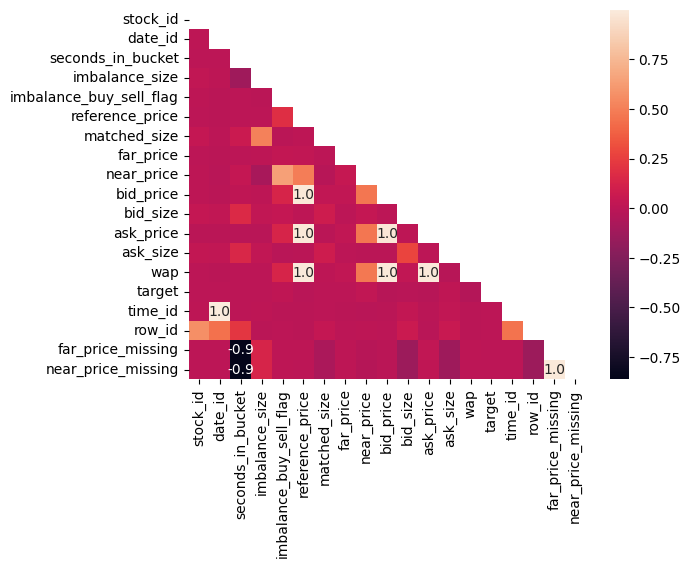

In [18]:
correlation = data.corr()
mask = np.triu(correlation)
ax = sns.heatmap(correlation, mask=mask, annot=True, fmt= '.1f')

for t in ax.texts:
    if abs(float(t.get_text()))>=0.8:
        t.set_text(t.get_text())
    else:
        t.set_text("")

Some hot spots need attention!

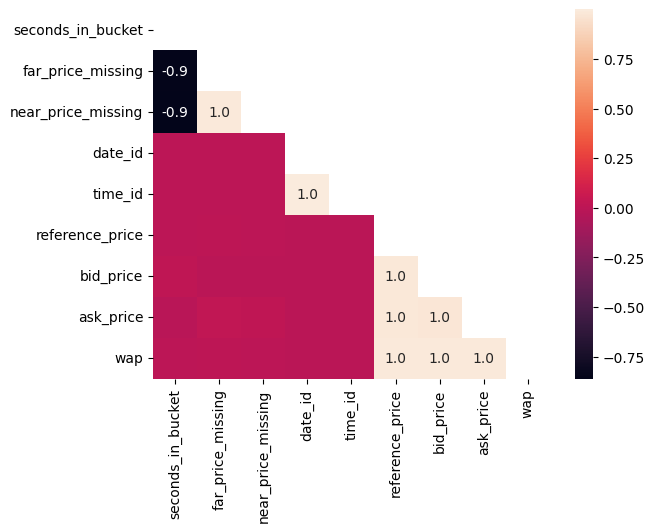

In [19]:
corr_reduced = data[['seconds_in_bucket',
                      'far_price_missing',
                      'near_price_missing',
                      'date_id',
                      'time_id',
                      'reference_price',
                      'bid_price',
                      'ask_price',
                      'wap']].corr()
mask = np.triu(corr_reduced)
ax = sns.heatmap(corr_reduced, mask=mask, annot=True, fmt='.1f')

for t in ax.texts:
    if abs(float(t.get_text()))>=0.8:
        t.set_text(t.get_text())
    else:
        t.set_text("")

3 hightly correlated groups are spotted:

   1. The price group
   
   wap / reference_price / bid_price / ask_price
   
   1. The id group
   
   date_id / time_id
   
   1. The weirdo
   
   seconds_in_bucket / near_price_missing / far_price_missing

**The price group treatement**
 - Eliminate reference_price, ask_price and bid_price as there are contained in the calculation of wap (weighted average price)
 
**The id group treatement**
 - No treatement is needed as the are just linear variable or index of trading operations and data_id will be dummy (0/1) variable encoded.

**The id group treatement**
 - No treatement is needed as the near&far price features are 0/1 flags of the estimated NaN values with hold no significant relationship with seconds_in_bucket which will be re-encoded in separate dummy variables.

In [20]:
data.drop(columns=['reference_price', 'bid_price', 'ask_price'], inplace=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5237760 entries, 0 to 5237979
Data columns (total 16 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 float64
 1   date_id                  float64
 2   seconds_in_bucket        float64
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  float64
 5   matched_size             float64
 6   far_price                float64
 7   near_price               float64
 8   bid_size                 float64
 9   ask_size                 float64
 10  wap                      float64
 11  target                   float64
 12  time_id                  float64
 13  row_id                   float64
 14  far_price_missing        float64
 15  near_price_missing       float64
dtypes: float64(16)
memory usage: 679.3 MB


## Dummy Variables Encoding

In [22]:
for c in data.columns:
    print(c, len(data[c].unique()), ' ', data[c].unique(), '\n')

stock_id 200   [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  70.
  71.  72.  73.  74.  75.  76.  77.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100.
 101. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 134. 136. 137. 138. 139. 140. 141. 142. 143. 144.
 145. 146. 147. 148. 149. 151. 152. 154. 155. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189.
 190. 191. 192. 193. 194. 195. 196. 197. 198.  78.  69. 156. 1

In [23]:
# selected features to re-encode
cols_to_dummies = [
    'stock_id',
    'date_id',
    'seconds_in_bucket',
    'imbalance_buy_sell_flag'
]

In [24]:
data = pd.get_dummies(data,
                      columns=cols_to_dummies,
                      sparse=True,
                      drop_first=True,
                      dtype=np.int8)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5237760 entries, 0 to 5237979
Columns: 747 entries, imbalance_size to imbalance_buy_sell_flag_1.0
dtypes: Sparse[int8, 0](735), float64(12)
memory usage: 608.8 MB


## Features to eliminate

The feature row_id is equivalent to 'date_id' + 'seconds_in_bucket' + 'stock_id'

In [26]:
data.drop(columns='row_id', inplace=True)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5237760 entries, 0 to 5237979
Columns: 746 entries, imbalance_size to imbalance_buy_sell_flag_1.0
dtypes: Sparse[int8, 0](735), float64(11)
memory usage: 568.9 MB


In [28]:
gc.collect()

0

In [29]:
# Save preprocessed dataset
# import pickle
# train.to_pickle('/kaggle/working/preprocessed_train')

In [30]:
gc.collect()

0

## train/test split

In [31]:
from sklearn.model_selection import train_test_split
 
y = data['target']
X = data.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,random_state=21, 
                                                    shuffle=False,stratify=None)

# **Modeling**

Bypassing the memory limitations by Out of Core training

In [35]:
# Helper functions

def generate_batch(X, y, chunksize):
    start = 0
    while start < len(X):
        end = min(start + chunksize, len(X))
        X_chunk, y_chunk = X[start:end], y[start:end]
        yield X_chunk, y_chunk
        start += chunksize
        
def batch_generator_test(X, chunk_size):
    start = 0
    while start < len(X):
        end = min(start + chunk_size, len(X))
        X_chunk = X[start:end]
        yield X_chunk
        start += chunk_size
                
def train_model(model, X, y):
    batch_generator = generate_batch(X, y, chunksize=10000)
    scores = []
    for X_chunk, y_chunk in batch_generator:
        model.partial_fit(X_chunk, y_chunk)
    
    return model

def scoring(train_model, X, y):
    batch_generator = generate_batch(X, y, chunksize=10000)
    scores = []
    for X_chunk, y_chunk in batch_generator:
        scores.append(mean_absolute_error(y_chunk, train_model.predict(X_chunk)))
        print(mean_absolute_error(y_chunk, train_model.predict(X_chunk)))
    
    return scores

def save_predictions(train_model, X, chunk_size=10000):
    predictions = []
    for X_chunk in batch_generator_test(X, chunk_size=10000):
        predictions += train_model.predict(X_chunk).tolist()
    return pd.DataFrame(predictions)

## Baseline model

In [37]:
from sklearn.linear_model import SGDRegressor
model = SGDRegressor(loss='huber', epsilon=0, penalty='l1', fit_intercept=True,
                     validation_fraction=.3, tol=1e-2)

In [38]:
# train baseline_model
baseline_model = train_model(model, X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklea

In [39]:
# training predictions
y_preds = save_predictions(model, X_test, chunk_size=10000)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklea

In [40]:
from sklearn.metrics import mean_absolute_error
baseline_score = mean_absolute_error(y_test, y_preds)
print('Baseline MAE Score: ', baseline_score)

Baseline MAE Score:  6.173055094200435


In [37]:
# # Save Baseline model
# import joblib
# joblib.dump(baseline_model, '/kaggle/working/baseline_model')

In [41]:
gc.collect()

0

## Ensemble Model

This ideas is getting predictions from two (sklearn) regression models with incremental learning (partial_fit attribute) and use them as features/variable to predict 'target'.

In [53]:
# First Model Predictions
sgd_model = SGDRegressor(loss='huber', epsilon=0, penalty='l1', fit_intercept=True,
                     validation_fraction=.3, tol=1e-2)

fit_sgd_model = train_model(sgd_model, X, y)

sgd_preds = save_predictions(sgd_model, X, chunk_size=10000)

In [55]:
# Second Model Predictions
from sklearn.linear_model import PassiveAggressiveRegressor
par_model = PassiveAggressiveRegressor(
    C=.1, 
    fit_intercept=True,
    max_iter=1000,
    shuffle=False,
    verbose=0,
    loss='epsilon_insensitive', epsilon=0,
    random_state=21, warm_start=False)

fit_par_model = train_model(par_model, X, y)

par_preds = save_predictions(par_model, X, chunk_size=10000)

In [56]:
# Second Stage Data
second_stage_data = pd.concat([sgd_preds, par_preds, y],
                              axis=1, sort=False)

In [57]:
second_stage_data.rename(columns= {0:'sgd_preds', 1:'par_preds', 2:'target'},
                         inplace=True)

second_stage_data.head()

,sgd_preds,sgd_preds,target
0,0.0,1.316425,-3.029704
1,0.0,0.041549,-5.519986
2,0.0,-0.000413,-8.389950
3,0.0,-0.027164,-4.010200
4,0.0,-0.458349,-7.349849


In [59]:
second_stage_data.dropna(inplace=True)

In [61]:
# final inference and results
y = second_stage_data['target']
X = second_stage_data.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,random_state=21, 
                                                    shuffle=False,stratify=None)

sgd_model = SGDRegressor(loss='huber', epsilon=0, penalty='l1', fit_intercept=True,
                     validation_fraction=.3, tol=1e-12)

final_model = train_model(sgd_model, X_train, y_train)

final_preds = save_predictions(sgd_model, X_test, chunk_size=10000)

final_score = mean_absolute_error(y_test, final_preds)

print('final MAE Score: ', final_score)

final MAE Score:  6.231292134319348
